# DCGAN for Image Generation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EmoryMLIP/DeepGenerativeModelingIntro/blob/main/examples/DCGAN.ipynb)


## Some References

- Original paper on GANs by [Goodfellow et al. (2014)](https://arxiv.org/abs/1406.2661)
- Tutorial by [Goodfellow (2017)](https://arxiv.org/abs/1701.00160)
- We use a Deep Convolutional GAN proposed by [Salimans et al. (2016)](https://arxiv.org/abs/1606.03498)
- Section 5.1 of our paper  [Introduction to Deep Generative Modeling](https://arxiv.org/abs/2103.05180)

## Short Mathematical Description

In training we approximately solve the saddle point problem

\begin{equation}
\newcommand{\E}{\mathbb{E}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\bftheta}{\boldsymbol{\theta}}
\newcommand{\bfphi}{\boldsymbol{\phi}}
\newcommand{\calX}{\mathcal{X}}
\newcommand{\calZ}{\mathcal{Z}}
\newcommand{\bfx}{\mathbf{x}}
\newcommand{\bfz}{\mathbf{z}}
\newcommand{\bfy}{\mathbf{y}}
\min_{\bftheta}\max_{\bfphi} J_{\rm GAN}(\bftheta, \bfphi) = \E_{\bfx\sim \calX} \left[\log(d_{\bfphi}(\bfx)) \right] + \E_{\bfz\sim \calZ} \left[ \log\left(1 - d_{\bfphi}(g_{\bftheta}(\bfz))\right) \right].
\end{equation}

where

- $g_{\bftheta} : \R^2 \to \R^{784}$ is the generator (here a convolutional neural network)
- $d_{\bfphi} : \R^{784} \to \R^2$ is the discriminator (here a convolutional neural network)



In [6]:
# install requirements  (Colab only)
import sys,os
if 'google.colab' in sys.modules:
    dgm_dir = '/content/DeepGenerativeModelingIntro/'
    if not os.path.exists(dgm_dir):
        !git clone git://github.com/EmoryMLIP/DeepGenerativeModelingIntro.git

    sys.path.append(os.path.dirname(dgm_dir))#%%

In [7]:
import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from os import path


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'image.interpolation' : None})
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 200

## Prepare Image Data

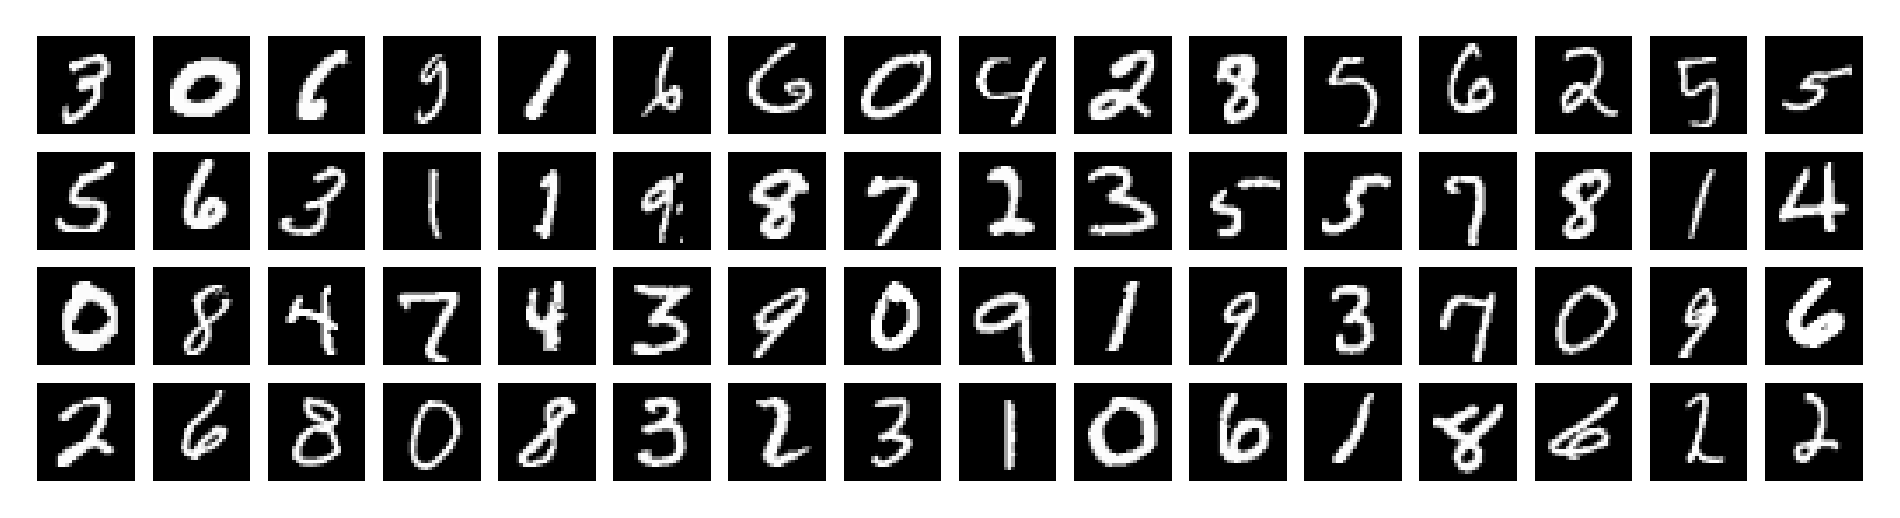

In [8]:
batch_size = 64
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

x,_ = next(iter(train_dataloader))
plt.Figure()
plt.imshow(torchvision.utils.make_grid(x,16,padding=5,pad_value=1.0).permute((1,2,0)),cmap='gray')
plt.axis("off")
plt.margins(0, 0)
plt.show()

## Select GAN Architecture

In [9]:
class Generator(nn.Module):
    def __init__(self,w,q):
        """
        :param w: number of channels on the finest level
        :param q: latent space dimension
        """
        super(Generator, self).__init__()
        self.w = w
        self.fc = nn.Linear(q, w * 2 * 7 * 7)
        self.conv2 = nn.ConvTranspose2d(w * 2, w, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(w, 1, kernel_size=4, stride=2, padding=1)

        self.bn1 = nn.BatchNorm2d(w)
        self.bn2 = nn.BatchNorm2d(2*w)

    def forward(self, z):
        """
        :param z: latent space sample
        :return: g(z)
        """
        gz = self.fc(z)
        gz = gz.view(gz.size(0), self.w * 2, 7, 7)
        gz = self.bn2(gz)
        gz = F.relu(gz)
        gz = self.conv2(gz)
        gz = self.bn1(gz)

        gz = F.relu(gz)
        gz = torch.sigmoid(self.conv1(gz))
        return gz

class Discriminator(nn.Module):
    def __init__(self, w,useSigmoid=True):
        """
        Discriminator for GANs
        :param w: number of channels on finest level
        :param useSigmoid: true --> DCGAN, false --> WGAN
        """
        super(Discriminator, self).__init__()
        self.w = w
        self.useSigmoid = useSigmoid
        self.conv1 = nn.Conv2d(1, w, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(w, w * 2, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(w * 2 * 7 * 7, 1)
        self.bn1 = nn.BatchNorm2d(w)
        self.bn2 = nn.BatchNorm2d(2*w)

    def forward(self,x):
        """
        :param x: MNIST image or generated image
        :return: d(x), value of discriminator
        """
        x = (x-0.5)/0.5 #
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x,0.2)
        x = self.conv2(x)
        x = self.bn2(x)

        x = F.leaky_relu(x,0.2)
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        if self.useSigmoid:
            x = torch.sigmoid(x)
        return x

q = 2 # latent space dimension
width_disc = 32 # width of discriminator
width_dec = 32 # width of decoder

g = Generator(width_dec,q).to(device)
d = Discriminator(width_disc,useSigmoid=True).to(device)

## Train the Generator and Discriminator

We alternate between ADAM steps of the generator and the discriminator.

In [10]:
optimizer_g = torch.optim.Adam(params=g.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(params=d.parameters(), lr=0.0002, betas=(0.5, 0.999))

his = np.zeros((0,3))

num_steps = 5 # number of training steps
plot_interval = 2  # plot solution every so many steps
init_g = "./results/VAEmnist-q-2-batch_size-%d-w_enc-%d-w_dec-%d-g.pt" % (batch_size,width_disc,width_dec) # path to .pt file that contains weights of a trained generator
out_file = "./results/DCGANmnist-q-2-batch_size-%d-w_disc-%d-w_dec-%d" % (batch_size,width_disc,width_dec)

retrain = False

if init_g is not None and path.exists(init_g):
    print("initialize g with weights in %s" % init_g)
    g.load_state_dict(torch.load(init_g ,map_location=torch.device(device)))

if retrain == False and path.exists(out_file + "-g.pt") and path.exists(out_file + "-d.pt") and path.exists(out_file + ".mat"):
    g.load_state_dict(torch.load("%s-g.pt" % (out_file),map_location=torch.device(device)))
    d.load_state_dict(torch.load("%s-d.pt" % (out_file),map_location=torch.device(device)))
    from scipy.io import loadmat
    his_file = loadmat("%s.mat" % (out_file))
    his = his_file['his']
    print("loaded results from %s" % out_file)

else:
    print((3*"--" + "device=%s, q=%d, batch_size=%d, num_steps=%d, w_disc=%d, w_dec=%d," + 3*"--") % (device, q, batch_size, num_steps, width_disc, width_dec))
    if out_file is not None:
        import os
        out_dir, fname = os.path.split(out_file)
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        print((3*"--" + "out_file: %s" + 3*"--") % (out_file))
    print((4*"%7s    ") % ("step","J_GAN","J_Gen","ProbDist"))

    from epsTest import epsTest

    train_JGAN = 0.0
    train_JGen = 0.0
    train_epsTest = 0.0
    num_ex = 0

    def inf_train_gen():
        while True:
            for images, targets in enumerate(train_dataloader):
                yield images,targets

    get_true_images = inf_train_gen()

    for step in range(num_steps):
        g.train()
        d.train()
        # update discriminator using - J_GAN = - E_x [log(d(x)] - E_z[1-log(d(g(z))]
        x = get_true_images.__next__()[1][0]
        x = x.to(device)
        dx = d(x)
        z = torch.randn((x.shape[0],q),device=device)
        gz = g(z)
        dgz = d(gz)
        J_GAN = - torch.mean(torch.log(dx)) - torch.mean(torch.log(1-dgz))
        optimizer_d.zero_grad()
        J_GAN.backward()
        optimizer_d.step()

        # update the generator using J_Gen = - E_z[log(d(g(z))]
        optimizer_g.zero_grad()
        z = torch.randn((x.shape[0], q), device=device)
        gz = g(z)
        dgz = d(gz)
        # J_Gen = -torch.mean(torch.log(dgz))
        J_Gen = torch.mean(torch.log(1-dgz))
        J_Gen.backward()
        optimizer_g.step()

        # update history
        train_JGAN -= J_GAN.item()*x.shape[0]
        train_JGen += J_Gen.item()*x.shape[0]
        train_epsTest += epsTest(gz.detach(), x)
        num_ex += x.shape[0]

        if (step + 1) % plot_interval == 0:
            train_JGAN /= num_ex
            train_JGen /= num_ex


            print(("%06d   " + 3*"%1.4e  ") %
                  (step + 1, train_JGAN, train_JGen, train_epsTest))
            his = np.vstack([his, [train_JGAN, train_JGen, train_epsTest]])

            plt.Figure()
            img = gz.detach().cpu()
            img -= torch.min(img)
            img /=torch.max(img)
            plt.imshow(torchvision.utils.make_grid(img, 16, 5,pad_value=1.0).permute((1, 2, 0)))
            plt.title("trainDCGANmnist: step=%d" % (step + 1))
            if out_file is not None:
                plt.savefig(("%s-step-%d.png") % (out_file, step + 1))
            plt.show()

            train_JGAN = 0.0
            train_JGen = 0.0
            train_epsTest = 0.0
            num_ex = 0

    if out_file is not None:
        torch.save(g.state_dict(), ("%s-g.pt") % (out_file))
        torch.save(d.state_dict(), ("%s-d.pt") % (out_file))

        from scipy.io import savemat
        savemat(("%s.mat") % (out_file), {"his":his})

initialize g with weights in ./results/VAEmnist-q-2-batch_size-64-w_enc-32-w_dec-32-g.pt
loaded results from ./results/DCGANmnist-q-2-batch_size-64-w_disc-32-w_dec-32


## Convergence

We plot the GAN loss and the loss of the generator.

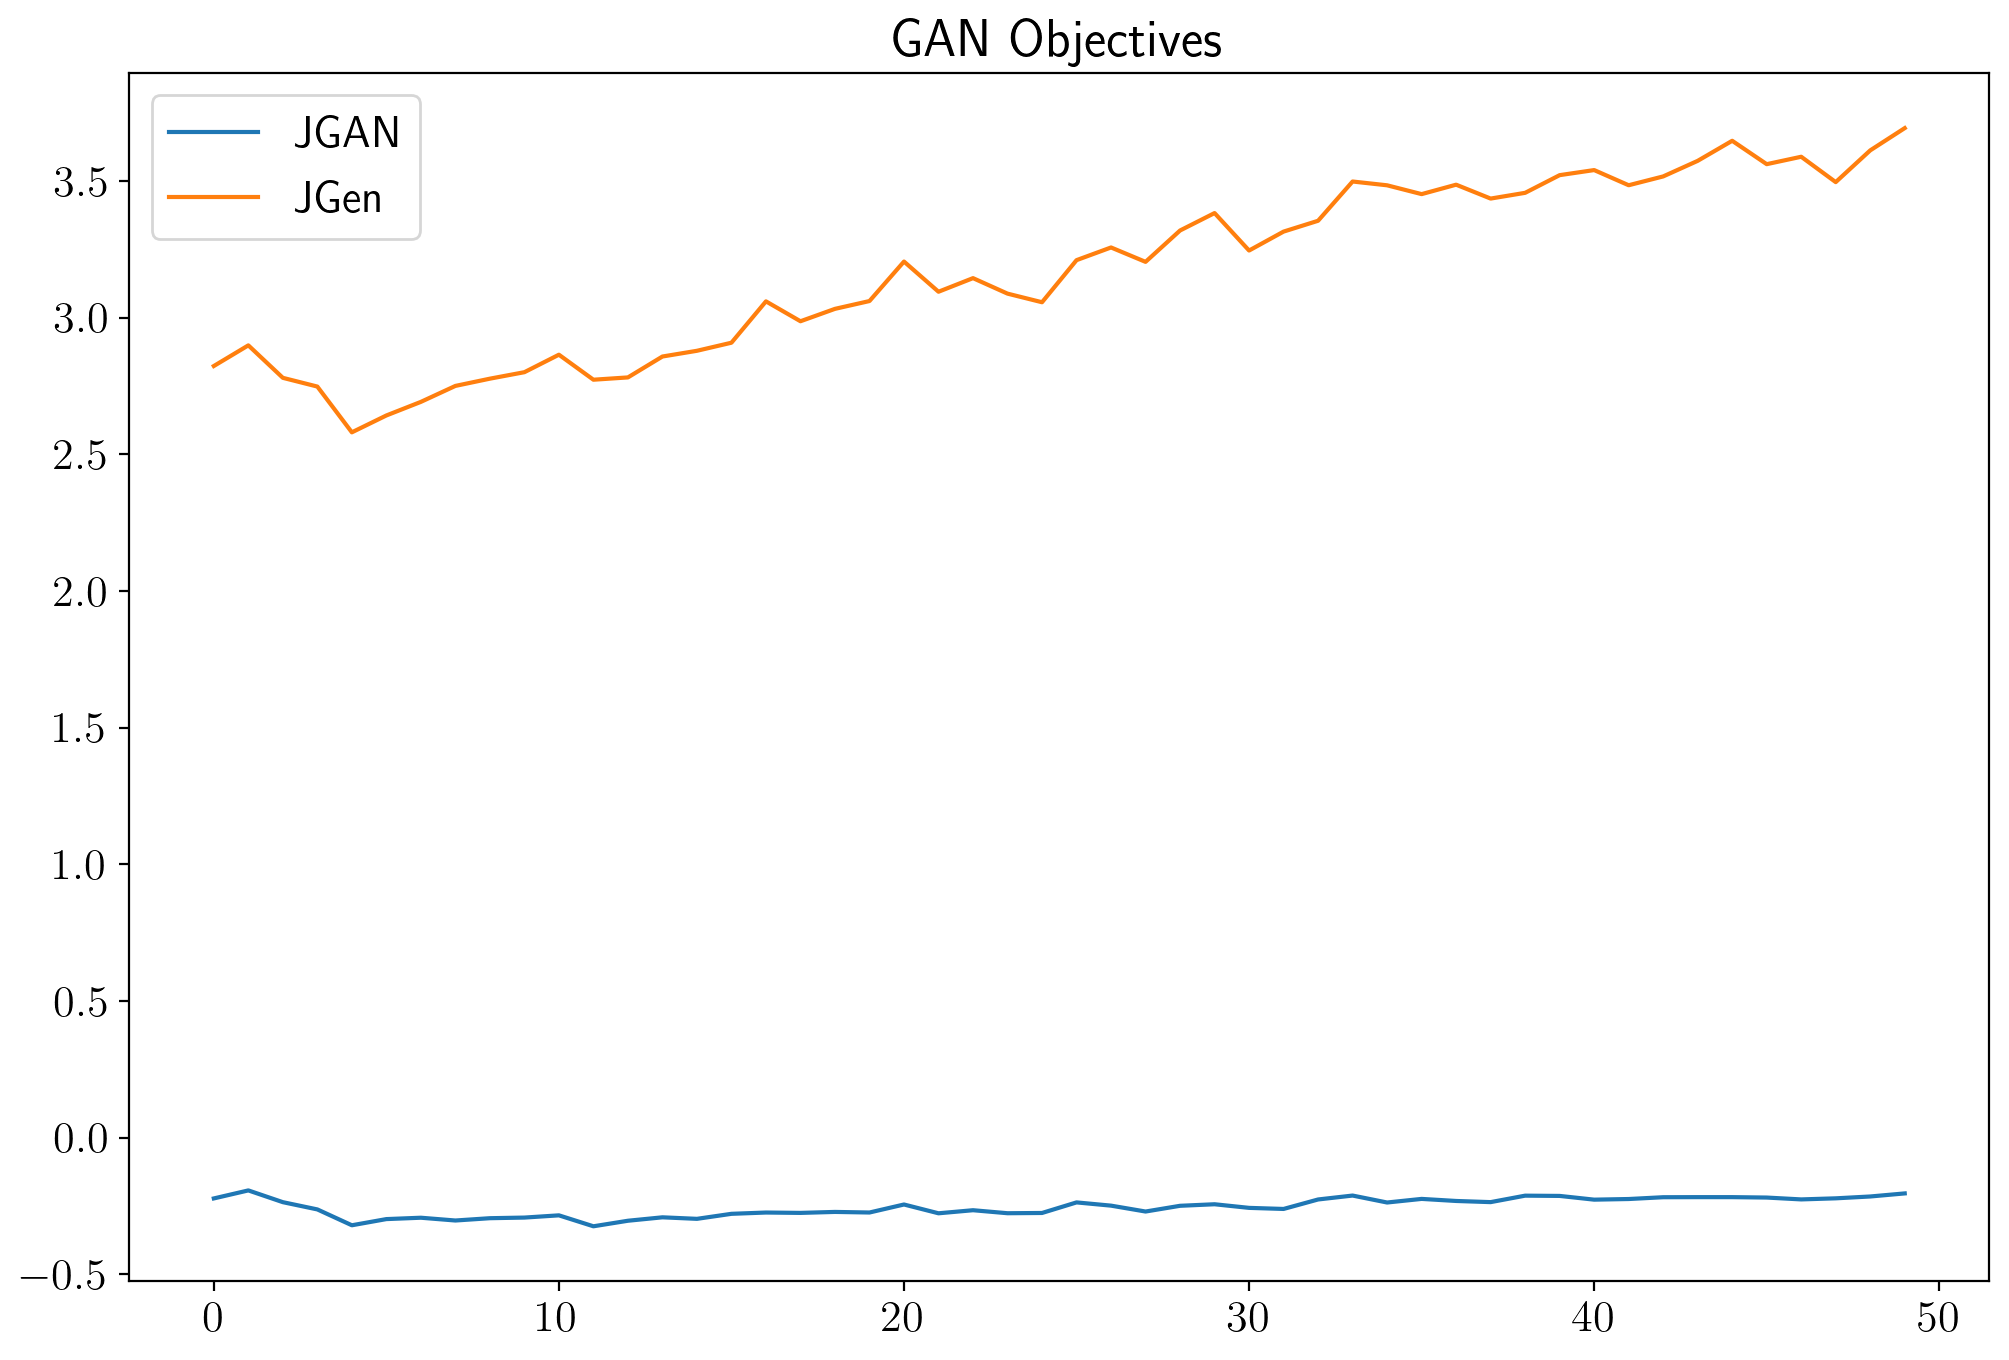

In [11]:
plt.Figure()
plt.plot(his[:,0:2])
plt.legend(("JGAN","JGen"))
plt.title("GAN Objectives")
plt.show()


## Show Samples

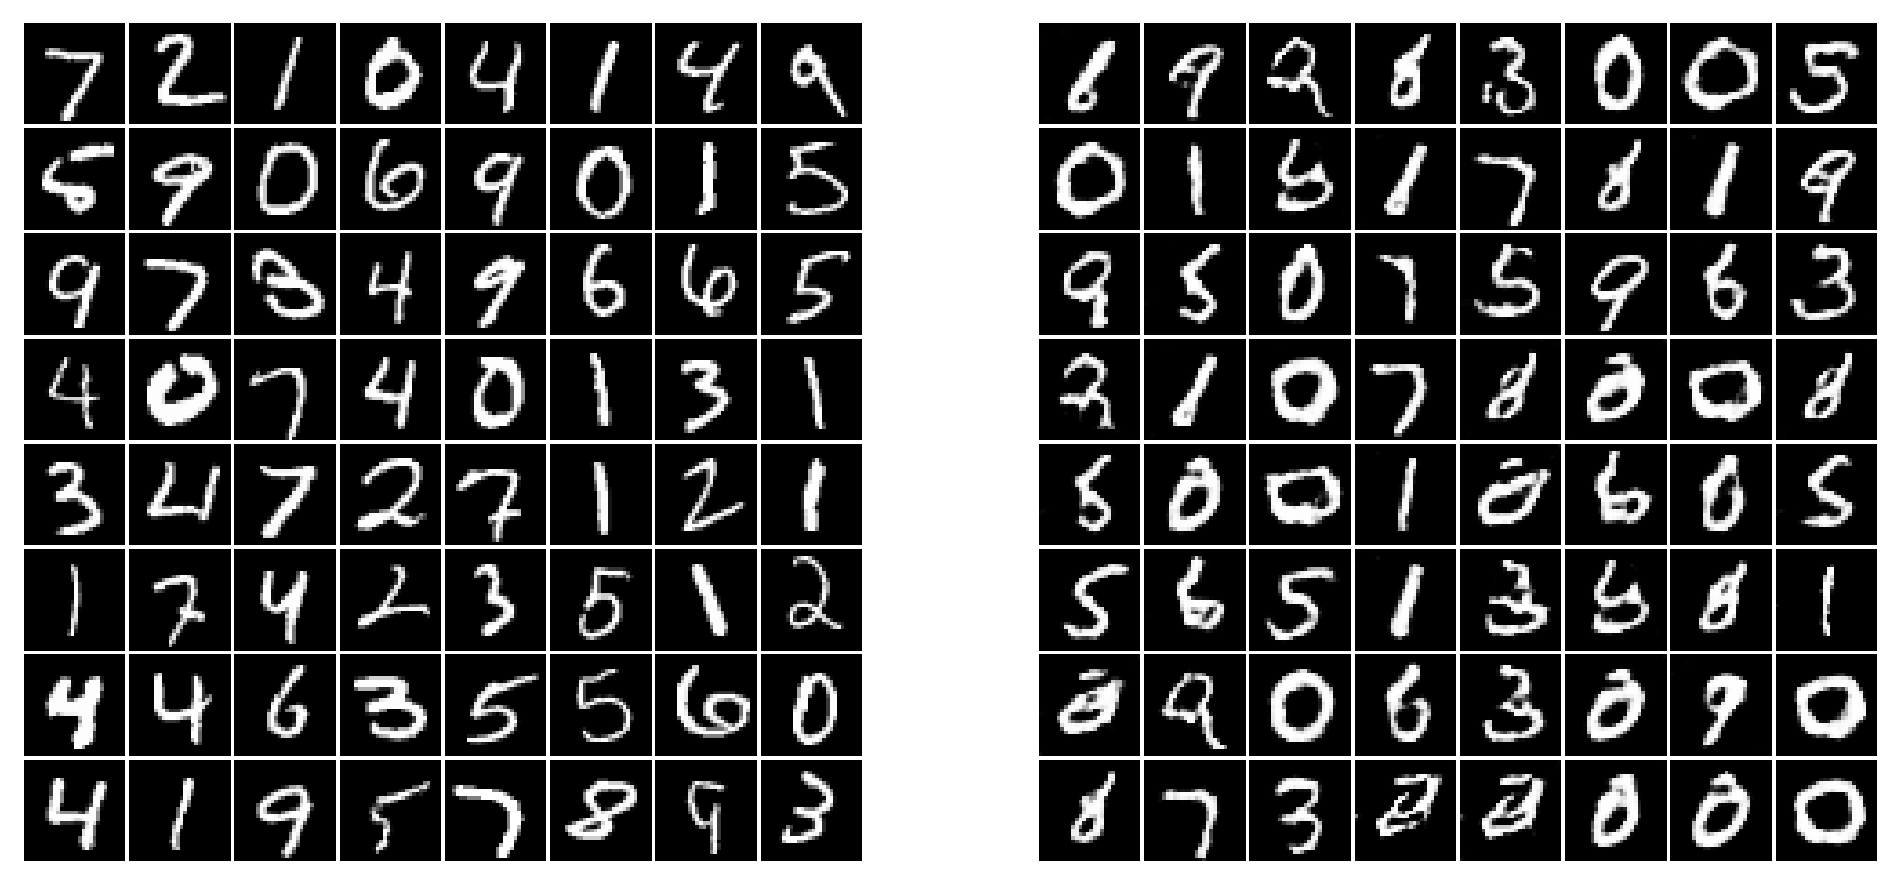

In [12]:
ncol = 8
x, _ = next(iter(test_dataloader))
plt.Figure()
plt.subplot(1,2,1)
plt.imshow(torchvision.utils.make_grid(x,ncol,1,pad_value=1).permute((1,2,0)),cmap='gray')
plt.axis("off")
plt.margins(0, 0)
plt.title("original images")

z = torch.randn((64,q),device=device)
gz = g(z)
plt.subplot(1,2,2)
plt.imshow(torchvision.utils.make_grid(gz.cpu().detach(),ncol,1,pad_value=1).permute((1,2,0)),cmap='gray')
plt.axis("off")
plt.margins(0, 0)
plt.title("generated images")
plt.show()

## Interpolate in Latent Space

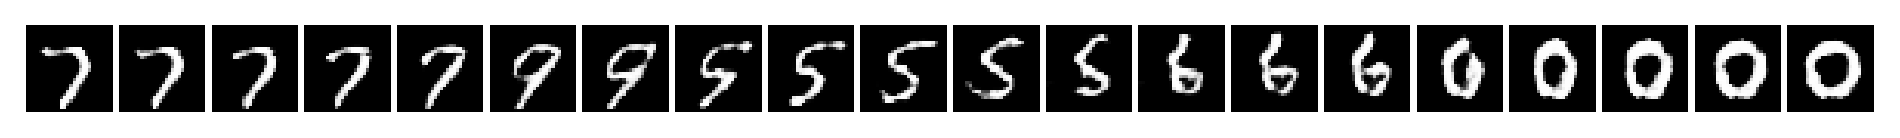

In [13]:
z1 = -torch.ones(1,2,device=device)
z2 = torch.ones(1,2,device=device)
with torch.no_grad():

    lam = torch.linspace(0,1,20,device=device).reshape(-1,1)
    zinter = z1*(1-lam) + z2*lam

    gz = g(zinter)

plt.Figure()
plt.imshow(torchvision.utils.make_grid(gz.cpu(),len(lam),2,pad_value=1).permute((1,2,0)),cmap='gray')
plt.axis("off")
plt.margins(0, 0)
plt.show()